# Compute airglow response to seismic-induced acoustic plane waves

In [1]:
%matplotlib widget
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from importlib import reload
from scipy import interpolate
import sys
from scipy import signal
import obspy

import airglow_response as ar

## Collect atmospheric data

In [13]:
reload(ar)

opt_atmosphere = dict(
    folder_data='./data/',
    use_kenda_data = False,
    gamma_kenda=11./9., 
    rel_path_to_kenda='./data/VER_profiles_from_kenda.csv'
)

f_rho, f_t, f_gamma, f_c, f_VER, f_VER_dayglow = ar.load_atmosphere(**opt_atmosphere)

## Build airglow scaler
Determines the median transmission coefficient between a vertical velocity of 1 m/s at 90 km altitude and corresponding amplitude in the dayglow and nightglow

In [ ]:
reload(ar)

opt_scaler = dict(
    freq_bins = np.logspace(np.log10(1e-2), np.log10(1), 4),
    store_id = 'GF_venus_Cold100_qssp', 
    strike=45.,
    dip=45., 
    rake=45.,
)
scaling_airglow = ar.compute_airglow_scaler(**opt_scaler)

In [ ]:
scaling_airglow_plot = scaling_airglow.groupby(['f1', 'f2',])['dayglow'].median().reset_index()
scaling_airglow_plot['dayglow_q25'] = scaling_airglow.groupby(['f1', 'f2',])['dayglow'].quantile(q=0.25).reset_index()['dayglow']
scaling_airglow_plot['dayglow_q75'] = scaling_airglow.groupby(['f1', 'f2',])['dayglow'].quantile(q=0.75).reset_index()['dayglow']

scaling_airglow_plot['nightglow'] = scaling_airglow.groupby(['f1', 'f2',])['nightglow'].median().reset_index()['nightglow']
scaling_airglow_plot['nightglow_q25'] = scaling_airglow.groupby(['f1', 'f2',])['nightglow'].quantile(q=0.25).reset_index()['nightglow']
scaling_airglow_plot['nightglow_q75'] = scaling_airglow.groupby(['f1', 'f2',])['nightglow'].quantile(q=0.75).reset_index()['nightglow']

In [ ]:
scaling_new = pd.read_csv('./data/data_airglow_scaling_from_seismo_median.csv')

plt.figure()

plt.plot(scaling_airglow_plot.f1, scaling_airglow_plot.dayglow, color='tab:blue', label='dayglow')
plt.fill_between(scaling_airglow_plot.f1, scaling_airglow_plot.dayglow_q25, scaling_airglow_plot.dayglow_q75, color='tab:blue', alpha=0.3)

plt.plot(scaling_airglow_plot.f1, scaling_airglow_plot.nightglow, color='tab:orange', label='dayglow')
plt.fill_between(scaling_airglow_plot.f1, scaling_airglow_plot.nightglow_q25, scaling_airglow_plot.nightglow_q75, color='tab:orange', alpha=0.3)

plt.plot(scaling_new.f1, scaling_new.dayglow, ls='--')
plt.plot(scaling_new.f1, scaling_new.nightglow, ls='--')

plt.legend(frameon=False)
plt.yscale('log')

In [ ]:
scaling_airglow_plot.to_csv('./data/data_airglow_scaling_from_seismo_median.csv', header=True, index=False)

## Determine airglow waveforms for specific examples
Converts seismic vertical velocities determined through QSSP into dayglow and nightglow perturbations

### Build QSSP traces

In [15]:
reload(ar)

epsilon = 5e3
delta_dist = 50e3
delta_depth = 5e3
dists = np.arange(50.e3+epsilon*0, 8000.e3+epsilon*0, delta_dist)
depths = np.arange(5e3, 50e3+delta_depth, delta_depth)
offset = 3000e3
north_shifts = dists#[:4]
east_shifts = np.array([0.])

opt_synthetics = dict(
    mw = 6.5,
    depth = depths[0],
    strike = 0., 
    dip = 45., 
    rake = 45.,
    store_id = 'GF_venus_Cold100_qssp',
    north_shifts = north_shifts, 
    east_shifts = east_shifts,
    base_folder='/projects/restricted/infrasound/data/infrasound/2023_Venus_inversion/',
    stf_type = None,
    #stf_type = 'triangle', 
    effective_duration = 25.
)

synthetic_traces, synthetic_traces_u, iNN, iEE, shape_init = ar.build_seismic_synthetics(**opt_synthetics)

### Plot QSSP 

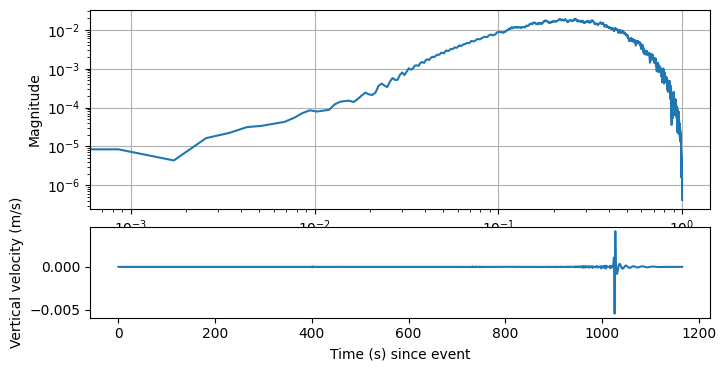

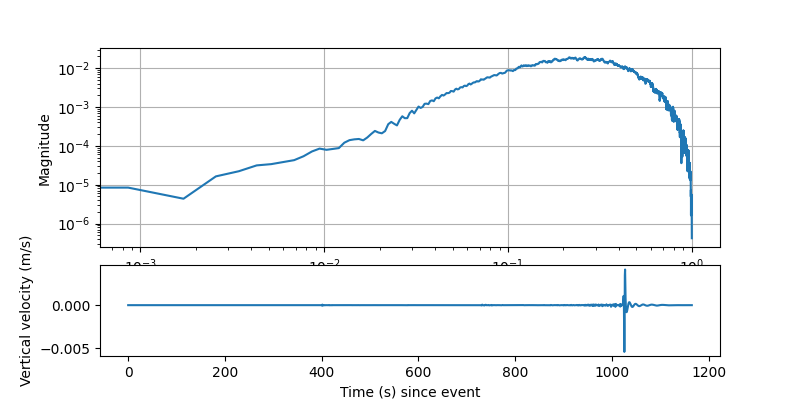

In [16]:
reload(ar)

ns, es = 3500, 0.
ar.plot_QSSP_traces(synthetic_traces, ns, es, north_shifts, iNN, east_shifts, iEE)

### Make time interpolated synthetic matrix out of QSSP traces

In [22]:
reload(ar)

dt = 0.5
times = np.arange(0., 2000., dt)
amps, amps_u = ar.build_amps_matrix(synthetic_traces, synthetic_traces_u, times)

100%|██████████| 159/159 [00:00<00:00, 4223.26it/s]


In [58]:
reload(ar)

opt_inputs = dict(
    ns = 3500., 
    es = 3500., 
    normalize_w_amplitude_at_90=False, 
    n_add=1000, 
    use_theoretical=False,
    freq_target=1./25., 
    do_density_scaling=False, 
    data_file='./data/attenuation_kenda.csv'
)
TIMES_DAYGLOW, ALTS_DAYGLOW, tau, c, amplification, Az, dzAz, dzrho, alpha, dVERdz, GF_f0, GF_f0_u, amp_at_90 = ar.get_inputs_for_airglow(amps, amps_u, dt, f_rho, f_c, f_VER_dayglow, f_VER, north_shifts, iNN, east_shifts, iEE, **opt_inputs)

### Produce estimate for one trace

In [42]:
reload(ar)

use_direct_deriv = True
amp_dayglow, amp_nightglow, uz_and_dzu, vz_and_dzv = ar.produce_one_estimate(TIMES_DAYGLOW, ALTS_DAYGLOW, tau, c, Az, dzAz, dzrho, alpha, f_rho, f_gamma, f_t, f_VER_dayglow, dVERdz, f_VER, GF_f0=GF_f0, GF_f0_u=GF_f0_u, use_direct_deriv=use_direct_deriv)

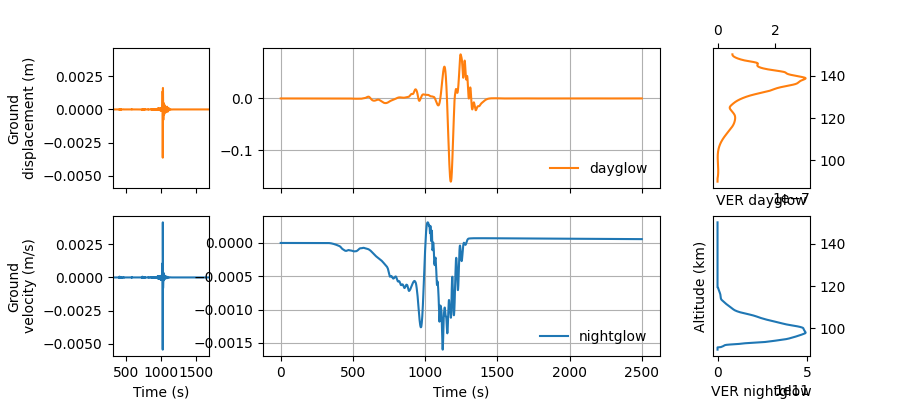

In [57]:
reload(ar)

opt_plot = dict(
    cut_off_stf=[300., 1700.],
    plot_SNR=False,
)
ar.plot_airglow_traces(amp_dayglow, amp_nightglow, GF_f0, GF_f0_u, amp_at_90, f_VER_dayglow, f_VER, TIMES_DAYGLOW, ALTS_DAYGLOW, **opt_plot)

### Produce batches of estimates

In [44]:
reload(ar)

opt_CPU = dict(
    factor_padding=1.25, 
    use_direct_deriv=True, 
    nb_CPU=1
)
alts_dayglow = ALTS_DAYGLOW[0,:]
#amps_dayglow, amps_nightglow = ar.build_amps_airglow_matrix(amps, amps_u, times, alts_dayglow,  tau, c, Az, dzAz, dzrho, alpha, f_rho, f_gamma, f_t, f_VER_dayglow, dVERdz, f_VER, factor_padding=1.25)
amps_dayglow, amps_nightglow = ar.build_amps_airglow_matrix_CPUs(amps, amps_u, times, alts_dayglow,  tau, c, Az, dzAz, dzrho, alpha, f_rho, f_gamma, f_t, f_VER_dayglow, dVERdz, f_VER, **opt_CPU)

Running serial


  0%|          | 0/159 [00:02<?, ?it/s]


KeyboardInterrupt: 

## Phase velocity inversion 

### Theoretical dispersion curves

In [ ]:
import numpy as np
from disba import PhaseDispersion, GroupDispersion          # pip install disba[full]

# --- custom 1‑D model (example) ---
file = './data/Cold_100_for_QSSP.csv'
layers = pd.read_csv(file, skiprows=2, delim_whitespace=True, header=None, names=['z','vp','vs','rho','Qp','Qs'])
h = np.diff(layers.z)
layers = layers.iloc[1:]
layers['h'] = h
layers = layers.iloc[:50]
layers.loc[layers.z==layers.z.max(), 'h'] = 0.
layers = layers.loc[:,['h','vp','vs','rho']].values

# --- frequencies (Hz) or periods (s) you want ---
#f = np.linspace(0.02, 0.25, 20)            # 0.02‑0.25 Hz → 4‑50 s
T = 1 / ff[::-1]                                   # disba wants periods, low→high

# --- Rayleigh‑wave phase velocity, fundamental mode (mode 0) ---
group_disp = GroupDispersion(*layers.T)             # unpack into h, vp, vs, ρ
group_disp = PhaseDispersion(*layers.T)             # unpack into h, vp, vs, ρ
rayleigh_0 = group_disp(T, mode=0, wave="rayleigh")   # namedtuple
rayleigh_1 = group_disp(T, mode=1, wave="rayleigh")   # namedtuple
rayleigh_2 = group_disp(T, mode=2, wave="rayleigh")   # namedtuple

### Loop over neighboring locations along source-station great circle

In [ ]:
from scipy.signal import butter, filtfilt, correlate, correlation_lags

def bandpass(sig, fs, f_lo, f_hi, order=4):
    """Zero‑phase Butterworth band‑pass."""
    nyq = 0.5 * fs
    b, a = butter(order, [f_lo/nyq, f_hi/nyq], btype='band')
    return filtfilt(b, a, sig)

def lag_of_max_xcorr(times, x, y, f_lo, f_hi, dist):
    """Band‑pass two signals then return lag (samples, seconds) of max ξ."""
    fs = 1./(times[1]-times[0])
    window = 1.#signal.windows.tukey(x.size, alpha=0.4)
    x_f = bandpass((x-x.mean())*window, fs, f_lo, f_hi, order=3)
    y_f = bandpass((y-y.mean())*window, fs, f_lo, f_hi, order=3)
    
    # normalise to unit variance to get the correlation coefficient directly
    x_n = (x_f - x_f.mean()) / x_f.std()
    y_n = (y_f - y_f.mean()) / y_f.std()

    eta = correlate(y_n, x_n, mode='full')
    k = np.argmax(eta)                       # index of max correlation
    lag_samples = k - (len(x_n) - 1)       # align “full” output
    lags = correlation_lags(len(y_n), len(x_n))
    
    if False:
        fig = plt.figure(figsize=(4,4))
        grid = fig.add_gridspec(2, 1)
        
        ax = fig.add_subplot(grid[0,0])
        ax.plot(times, x*window)
        ax.plot(times, y*window)
        ax.set_title(f'{1./f_hi:.4f} - {1./f_lo:.4f} : {1e-3*dist/(lag_samples/ fs):.1f}')
    
        ax = fig.add_subplot(grid[1,0])
        ax.plot(times, x_n)
        ax.plot(times, y_n)
        
    if False:
        plt.figure()
        plt.plot(lags, eta)
        plt.title(f'{lags[eta.argmax()]} | {lag_samples}')
    
    return lag_samples, lag_samples / fs, eta[k]

import numpy as np
from scipy.signal import coherence, welch

def phase_velocity(x, y, fs, d, fmin, fmax, coh_thresh=0.8):
    win   = np.hanning(len(x))
    X     = np.fft.rfft(x*win)
    Y     = np.fft.rfft(y*win)
    freqs = np.fft.rfftfreq(x.size, 1/fs)

    Cxy   = X * np.conj(Y)
    phase = np.unwrap(np.angle(Cxy))
    tau   = -phase / (2*np.pi*np.where(freqs==0, np.inf, freqs))
    vphi  = d / tau                             # phase velocity (m/s)

    # spectral coherence on identical grid
    coh   = np.abs(Cxy)**2 / (np.abs(X)**2 * np.abs(Y)**2)

    band  = (freqs >= fmin) & (freqs <= fmax)
    good  = band & (coh > coh_thresh)
    #print('coh > coh_thresh', np.any(coh > coh_thresh), phase.max(), phase.min())

    return freqs[good], vphi[good]

doffset = 1600.
offsets = np.arange(2000., 8001., doffset)
azs = np.linspace(0., 350, 10)
unknown = amps_dayglow
unknown = amps_nightglow
unknown = amps
ff = 1./np.arange(5., 125., 10.)
ff = ff[::-1]
n_add = 5000

plot = False
pd_phase_disp = pd.DataFrame()
for iff, (f_lo, f_hi) in enumerate(zip(ff[:-1], ff[1:])):
    for az in azs:
        if plot:
            plt.figure()
        for ioffset, offset in enumerate(offsets):

            es, ns = np.cos(np.radians(az))*offset, np.sin(np.radians(az))*offset
            idx_2 = np.argmin(np.sqrt((north_shifts[iNN]/1e3-ns)**2+(east_shifts[iEE]/1e3-es)**2))
            y = unknown[idx_2,:]
            y = np.r_[np.zeros(n_add), y, np.zeros(n_add)]

            fs = 1./(times[1]-times[0])
            window = 1.#signal.windows.tukey(x.size, alpha=0.4)
            x_f = bandpass(y-y.mean(), fs, f_lo, f_hi, order=3)

            time_loc = np.arange(x_f.size)/fs
            if plot:
                plt.plot(time_loc, x_f/x_f.max()+ioffset, zorder=1)

            if ioffset > 0:
                idiff = np.argmax(abs(x_f)) - imax
                itime = idiff/fs
                dist = np.sqrt((ns-nslast)**2 + (es-eslast)**2)
                ivel = dist/itime
                lag_smpl, lag_sec, r_max = lag_of_max_xcorr(time_loc, y_last, y, f_lo, f_hi, dist)
                if plot:
                    plt.text(time_loc[-1], ioffset, f'vel: {ivel:.1f} | time: {itime:.1f} | lag_sec: {lag_sec:.1f}', ha='right')
                
                ff_p, vphi = phase_velocity(y, y_last, fs, dist, f_lo, f_hi, coh_thresh=0.5)
                
                """
                print(vphi)
                
                plt.figure()
                plt.plot(y_last)
                plt.plot(y)
                break
                """
                
                loc_input = dict(f_lo=f_lo, f_hi=f_hi, lag_sec=lag_sec, dist=dist, ns=ns, es=es, r_max=r_max, az=az, vphi=np.median(vphi))
                pd_phase_disp = pd.concat([pd_phase_disp, pd.DataFrame([loc_input])])

            imax = np.argmax(abs(x_f))
            nslast, eslast = ns, es
            y_last = y

            if plot:
                plt.scatter(time_loc[imax], (x_f/x_f.max())[imax]+ioffset, color='black', marker='*', zorder=10)
                plt.text(0, ioffset, f'arrival: {imax/fs:.1f} s', ha='left')

                idx_t = 0
                period_RW = rayleigh_0.period[idx_t]
                vel_RW = rayleigh_0.velocity[idx_t]
                plt.scatter(n_add/fs+ns/vel_RW, ioffset, color='red', marker='|', zorder=20)
                plt.text(0, ioffset-0.5, f'diff group: {n_add/fs+ns/vel_RW-imax/fs:.1f} s', ha='left')

        if plot:
            plt.title(f'{1./f_hi:.4f} - {1./f_lo:.4f}')
    
pd_phase_disp.reset_index(drop=True, inplace=True)

In [ ]:
pd_phase_disp_median = pd_phase_disp.groupby('f_lo').median().reset_index()
pd_phase_disp_q25 = pd_phase_disp.groupby('f_lo').quantile(q=0.25).reset_index()
pd_phase_disp_q75 = pd_phase_disp.groupby('f_lo').quantile(q=0.75).reset_index()

plt.figure()
plt.scatter(1./pd_phase_disp.f_lo, pd_phase_disp.vphi, alpha=0.2, color='tab:red')
plt.plot(1./pd_phase_disp_median.f_lo, pd_phase_disp_median.vphi, label='median', color='tab:red')
plt.plot(rayleigh_0.period, rayleigh_0.velocity, label='mode 0', color='tab:orange', ls='--')
plt.plot(rayleigh_1.period, rayleigh_1.velocity, label='mode 1', color='tab:blue', ls='--')
plt.plot(rayleigh_2.period, rayleigh_2.velocity, label='mode 2', color='tab:green', ls='--')
plt.fill_between(1./pd_phase_disp_q25.f_lo, pd_phase_disp_q25.vphi, pd_phase_disp_q75.vphi, alpha=0.3, color='grey')
plt.xscale('log')
plt.legend(frameon=False)
plt.ylim([2.5, 5.5])
plt.xlabel('Period (s)')
plt.ylabel('Phase velocity (km/s)')

In [ ]:
pd_phase_disp.loc[:,'vphi'] /= 1e3

In [ ]:
plt.figure()
plt.pcolormesh(amps[:,1000].reshape(shape_init))